# **LPS - Workflow Example**

In summary, this workflow contains:

- Setup access to S3
- Catalogue search using STAC API
- Download a Sentinel-2 data product from S3
- Briefly explore the product
- Run a simple SNAP workflow (Read, Subset, BandMath (NDVI)) in three ways:
  - use the Java-Python mapping provided by Snappy
  - use SNAP GPF operators with Snappy
  - create and execute a SNAP GPF xml graph using SNAPISTA 
- Cleanup

- ---

## **1. Import Python packages**

**Note:** The imports of *esa_snappy* and *snapista* may result in various Info/Warning/Error messages from SNAP core modules. They can be ignored here.

In [108]:
# General
import os
import sys
import subprocess
import sysconfig
import requests
import json

# S3 API
import boto3

# esa_snappy
import esa_snappy

# Snapista
import snapista
from snapista import Graph
from snapista import Operator
from snapista import TargetBand
from snapista import TargetBandDescriptors

---

## **2. Get credentials for S3 access**

**Note:** Before using this NB for the first time in a new server, create a text file '.env' in your home directory with two lines giving your CDSE username/password:
```
CDSE_USERNAME=myusername
CDSE_PASSWORD=mypassword
```

Basically, credentials for S3 access can be created in the [S3 keys manager dashboard](https://eodata-s3keysmanager.dataspace.copernicus.eu/panel/s3-credentials).
(This does not seem to work correctly for everyone: ok for PL, but not for OD. TODO: investigate)

Below we follow an approach using temporary credentials which will be deleted when no longer needed.
See details at [https://documentation.dataspace.copernicus.eu/APIs/S3.html#example-script-to-download-product-using-python](https://documentation.dataspace.copernicus.eu/APIs/S3.html#example-script-to-download-product-using-python)

##### ***Configuration parameters:***

In [111]:
config = {
    "auth_server_url": "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
    "odata_base_url": "https://catalogue.dataspace.copernicus.eu/odata/v1/Products",
    "s3_endpoint_url": "https://eodata.dataspace.copernicus.eu",
}

In [112]:
from dotenv import load_dotenv
load_dotenv()
username = os.getenv('CDSE_USERNAME')
password = os.getenv('CDSE_PASSWORD')
#print(username)
#print(password)


##### ***Retrieve an access token:***

In [113]:
###################################################################################################
def get_access_token(config, username, password):
    """
    Retrieve an access token from the authentication server.
    This token is used for subsequent API calls.
    """
    auth_data = {
        "client_id": "cdse-public",
        "grant_type": "password",
        "username": username,
        "password": password,
    }
    response = requests.post(config["auth_server_url"], data=auth_data, verify=True, allow_redirects=False)
    if response.status_code == 200:
        return json.loads(response.text)["access_token"]
    else:
        print(f"Failed to retrieve access token. Status code: {response.status_code}")
        exit(1)

###################################################################################################
access_token = get_access_token(config, username, password)

##### ***Set up headers for API calls:***

In [114]:
headers = {
    "Authorization": f"Bearer {access_token}",
    "Accept": "application/json"
}

##### ***Create temporary S3 credentials:***

In [115]:
###################################################################################################
def get_temporary_s3_credentials(headers):
    """
    Create temporary S3 credentials by calling the S3 keys manager API.
    """
    credentials_response = requests.post("https://s3-keys-manager.cloudferro.com/api/user/credentials", headers=headers)
    if credentials_response.status_code == 200:
        s3_credentials = credentials_response.json()
        print("Temporary S3 credentials created successfully.")
        #print(f"access: {s3_credentials['access_id']}")
        #print(f"secret: {s3_credentials['secret']}")
        return s3_credentials
    else:
        print(f"Failed to create temporary S3 credentials. Status code: {credentials_response.status_code}")
        print("Product download aborted.")
        exit(1)

###################################################################################################
s3_credentials = get_temporary_s3_credentials(headers)

Temporary S3 credentials created successfully.


---

## **3. Set up area and time interval of interest**
The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. 
You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

The selected area and time interval below will find just one product from the search: S2A_MSIL1C_20180803T103021_N0206_R108_T32UNE_20180803T142136, which includes the Hamburg area.

In [116]:
aoi_coords_wgs84 = [9.8, 53.45, 10.25, 53.6]
resolution = 60

# Define a time interval of just 1 day:
time_interval = "2018-08-03", "2018-08-04"

---

## **4. Catalog API: init catalog and do the search**
To search and discover data, we use the Catalog API. Sentinel Hub Catalog API (or shortly "Catalog") is an API implementing the STAC Specification, providing geospatial information for data available in Sentinel Hub.

In [117]:
from pystac_client import Client
from pathlib import Path

catalog = Client.open('https://stac.dataspace.copernicus.eu/v1')
collection = catalog.get_collection("sentinel-2-l1c")
collection.title

itemsearch = catalog.search(
    collections=["sentinel-2-l1c"],
    bbox=aoi_coords_wgs84,
    datetime=[time_interval[0], time_interval[1]],

)

msil1c_results = list(itemsearch.items())
base_s3_path = str(Path(msil1c_results[0].assets["product_metadata"].href).parent)
base_s3_path

's3:/eodata/Sentinel-2/MSI/L1C_N0500/2018/08/03/S2A_MSIL1C_20180803T103021_N0500_R108_T32UNE_20230730T062418.SAFE'

---

## **5. Download L1C SAFE product from S3**

In this step, the product found from the search above is downloaded as file. This is necessary because the SNAP API needs a file representation of an input product.

The download progress of each file of the SAFE product will be shown below. 

**Note:** Sometimes this step results in a '403 Forbidden' on CDSE Jupyter Hub. In that case just try to repeat... 

In [118]:
from tqdm.notebook import tqdm  # For proper use in Jupyter NB, use tqdm.notebook instead of tqdm!! See https://www.datacamp.com/tutorial/tqdm-python

##################################################################

s3_resource=boto3.resource('s3',aws_access_key_id=s3_credentials["access_id"], aws_secret_access_key=s3_credentials["secret"], endpoint_url=config["s3_endpoint_url"])

# For processing, download S2 MSIL1C SAFE product from result list found above:
l1c_product_to_process = msil1c_results[0]
print("Product ID: " + l1c_product_to_process.id)
product_path = str(Path(l1c_product_to_process.assets["product_metadata"].href).parent)

prefix_length = len("s3://") if product_path.startswith("s3://") else len("s3:/")
bucketname = product_path[prefix_length : product_path.find("/", prefix_length)]  # 'EODATA'
prefix_length = prefix_length + len(bucketname) + 1

bucket=s3_resource.Bucket(bucketname)

target = "./"
l1c_product_to_process = product_path[prefix_length:] # e.g. "Sentinel-2/MSI/L1C_N0500/2018/08/03/S2A_MSIL1C_20180803T103021_N0500_R108_T32UNE_20230730T062418.SAFE/"
#print("l1c_product_to_process: " + l1c_product_to_process)

l1c_files = bucket.objects.filter(Prefix=l1c_product_to_process)
list(l1c_files)
if not list(l1c_files):
    raise FileNotFoundError(f"Could not find any files for {l1c_product_to_process}")

failed_downloads = []
for file in l1c_files:
    os.makedirs(os.path.dirname(file.key), exist_ok=True)

    client = s3_resource.meta.client
    s3_key = file.key
    local_path = f"{target}{file.key}"
    
    try:
        file_size = client.head_object(Bucket=bucketname, Key=s3_key)['ContentLength']
        formatted_filename = os.path.basename(local_path) + ' '
        with tqdm(total=file_size, unit='B', unit_scale=True, desc=formatted_filename, bar_format='{desc:.40}| {percentage:3.0f}% {n_fmt}/{total_fmt}B') as pbar:
            def progress_callback(bytes_transferred):
                pbar.update(bytes_transferred)
    
            client.download_file(bucketname, s3_key, local_path, Callback=progress_callback)
    except Exception as e:
        print(f"Failed to download {s3_key}. Error: {e}")
        failed_downloads.append(s3_key)  # TODO: print list if length > 0

if not failed_downloads:
    print("Product download complete.")
else:
    print("Product download incomplete:")


Product ID: S2A_MSIL1C_20180803T103021_N0500_R108_T32UNE_20230730T062418


MTD_DS.xml |   0% 0.00/23.2MB

FORMAT_CORRECTNESS.xml |   0% 0.00/24.5kB

GENERAL_QUALITY.xml |   0% 0.00/8.16kB

GEOMETRIC_QUALITY.xml |   0% 0.00/9.37kB

RADIOMETRIC_QUALITY.xml |   0% 0.00/7.51kB

SENSOR_QUALITY.xml |   0% 0.00/4.96kB

AUX_CAMSRE |   0% 0.00/2.97kB

AUX_ECMWFT |   0% 0.00/1.62kB

T32UNE_20180803T103021_B01.jp2 |   0% 0.00/3.77MB

T32UNE_20180803T103021_B02.jp2 |   0% 0.00/105MB

T32UNE_20180803T103021_B03.jp2 |   0% 0.00/110MB

T32UNE_20180803T103021_B04.jp2 |   0% 0.00/117MB

T32UNE_20180803T103021_B05.jp2 |   0% 0.00/33.9MB

T32UNE_20180803T103021_B06.jp2 |   0% 0.00/33.8MB

T32UNE_20180803T103021_B07.jp2 |   0% 0.00/33.9MB

T32UNE_20180803T103021_B08.jp2 |   0% 0.00/135MB

T32UNE_20180803T103021_B09.jp2 |   0% 0.00/3.76MB

T32UNE_20180803T103021_B10.jp2 |   0% 0.00/1.67MB

T32UNE_20180803T103021_B11.jp2 |   0% 0.00/33.8MB

T32UNE_20180803T103021_B12.jp2 |   0% 0.00/33.7MB

T32UNE_20180803T103021_B8A.jp2 |   0% 0.00/33.9MB

T32UNE_20180803T103021_TCI.jp2 |   0% 0.00/135MB

MTD_TL.xml |   0% 0.00/546kB

FORMAT_CORRECTNESS.xml |   0% 0.00/28.9kB

GENERAL_QUALITY.xml |   0% 0.00/4.33kB

GEOMETRIC_QUALITY.xml |   0% 0.00/5.22kB

MSK_CLASSI_B00.jp2 |   0% 0.00/18.0kB

MSK_DETFOO_B01.jp2 |   0% 0.00/16.3kB

MSK_DETFOO_B02.jp2 |   0% 0.00/69.9kB

MSK_DETFOO_B03.jp2 |   0% 0.00/70.2kB

MSK_DETFOO_B04.jp2 |   0% 0.00/70.2kB

MSK_DETFOO_B05.jp2 |   0% 0.00/28.9kB

MSK_DETFOO_B06.jp2 |   0% 0.00/28.8kB

MSK_DETFOO_B07.jp2 |   0% 0.00/28.9kB

MSK_DETFOO_B08.jp2 |   0% 0.00/70.2kB

MSK_DETFOO_B09.jp2 |   0% 0.00/16.3kB

MSK_DETFOO_B10.jp2 |   0% 0.00/16.4kB

MSK_DETFOO_B11.jp2 |   0% 0.00/28.9kB

MSK_DETFOO_B12.jp2 |   0% 0.00/28.9kB

MSK_DETFOO_B8A.jp2 |   0% 0.00/29.0kB

MSK_QUALIT_B01.jp2 |   0% 0.00/14.8kB

MSK_QUALIT_B02.jp2 |   0% 0.00/58.4kB

MSK_QUALIT_B03.jp2 |   0% 0.00/58.5kB

MSK_QUALIT_B04.jp2 |   0% 0.00/59.0kB

MSK_QUALIT_B05.jp2 |   0% 0.00/14.6kB

MSK_QUALIT_B06.jp2 |   0% 0.00/14.6kB

MSK_QUALIT_B07.jp2 |   0% 0.00/14.7kB

MSK_QUALIT_B08.jp2 |   0% 0.00/60.4kB

MSK_QUALIT_B09.jp2 |   0% 0.00/14.8kB

MSK_QUALIT_B10.jp2 |   0% 0.00/21.8kB

MSK_QUALIT_B11.jp2 |   0% 0.00/31.1kB

MSK_QUALIT_B12.jp2 |   0% 0.00/31.7kB

MSK_QUALIT_B8A.jp2 |   0% 0.00/14.9kB

SENSOR_QUALITY.xml |   0% 0.00/5.30kB

T32UNE_20180803T103021_PVI.jp2 |   0% 0.00/167kB

UserProduct_index.html |   0% 0.00/5.79kB

UserProduct_index.xsl |   0% 0.00/10.0kB

banner_1.png |   0% 0.00/42.4kB

banner_2.png |   0% 0.00/58.6kB

banner_3.png |   0% 0.00/44.8kB

star_bg.jpg |   0% 0.00/1.89kB

INSPIRE.xml |   0% 0.00/18.6kB

MTD_MSIL1C.xml |   0% 0.00/45.8kB

S2A_MSIL1C_20180803T103021_N0500_R108_T3|   0% 0.00/33.2kB

manifest.safe |   0% 0.00/48.7kB

S2_User_Product_Level-1C_Metadata.xsd |   0% 0.00/1.14kB

Product download complete.


##### ***Delete temporary S3 credentials:***

After S3 access is no longer needed, we should remove the temporary S3 credentials.

In [119]:
###################################################################################################
def delete_temporary_s3_credentials(headers):
    """
    Delete temporary S3 credentials by calling the S3 keys manager API.
    """
    delete_response = requests.delete(f"https://s3-keys-manager.cloudferro.com/api/user/credentials/access_id/{s3_credentials['access_id']}", headers=headers)
    if delete_response.status_code == 204:
        print("Temporary S3 credentials deleted successfully.")
    else:
        print(f"Failed to delete temporary S3 credentials. Status code: {delete_response.status_code}")

###################################################################################################
delete_temporary_s3_credentials(headers)

Temporary S3 credentials deleted successfully.


---

## **6. Explore the data product**

We will below briefly explore the downloaded Sentinel-2 L1C product.

A Sentinel-2 Level-1C Collection 1 product provides orthorectified Top-Of-Atmosphere (TOA) reflectance, with sub-pixel multispectral and multitemporal registration accuracy. Technical quality masks are included in the product. Some of the L1C products main characteristics are listed in the table below.

| Name | Level-1C |
|:--------|:--------|
|  High-level Description   | Top-of-atmosphere reflectances in cartographic geometry for 13 spectral bands | 
|  Data Characteristics   |  UTM/WGS84 projection, JPEG2000 image format | 
|  DEM used   |  Copernicus DEM at 30 m  | 
|  Auxiliary Data   |  CAMS, ECMWF  | 
|  Data Volume   |  700 MB (each 100x100 km2)  | 

L1C Products are a compilation of elementary granules of fixed size, within a single orbit. A granule is the minimum indivisible partition of a product (containing all possible spectral bands). For Level-1C and Level-2A, the granules, also called tiles, are 100x100km2 ortho-images in UTM/WGS84 projection. The UTM (Universal Transverse Mercator) system divides the Earth’s surface into 60 zones. Each UTM zone has a vertical width of 6° of longitude and horizontal width of 8° of latitude. Tiles are approximately 700 MB in size. Tiles can be fully or partially covered by image data.

Many more details and further links can be found at:

[https://sentinels.copernicus.eu/sentinel-data-access/sentinel-products/sentinel-2-data-products/collection-1-level-1c](https://sentinels.copernicus.eu/sentinel-data-access/sentinel-products/sentinel-2-data-products/collection-1-level-1c)

The image below shows a visualization (RGB) of the downloaded product 'S2A_MSIL1C_20180803T103021_N0500_R108_T32UNE_20230730T062418' in SNAP Desktop. We have a scene with mostly clear skies (few shallow clouds only) showing Hamburg and surrounding area.

<img src="S2A_MSIL1C_20180803T103021_N0206_R108_T32UNE_20180803T142136_RGB.png" alt="JupyterLab web page" style="max-width: 100%; height: auto;" width: auto>

---

## **7. Example of a workflow using the SNAP API from Python**

The following simple example reads raster data from two bands (B4 and B8) of the downloaded S2 L1C product, computes/displays a simple NDVI, and saves the NDVI image as png.

##### ***Some more imports:***

In [120]:
from esa_snappy import ProductIO  
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

##### ***Read the data product into SNAP:***

In [121]:
p = ProductIO.readProduct(l1c_product_to_process)

INFO: eu.esa.opt.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32632


##### ***Print some information:***

In [122]:
print('Number of bands: ' + str(p.getNumBands()))

b4 = p.getBand('B4')
w = b4.getRasterWidth()
h = b4.getRasterHeight()
print('Band B4 Raster width: ' + str(b4.getRasterWidth()))
print('Band B4 Raster height: ' + str(b4.getRasterHeight()))
print('Band B4 Wavelength: ' + str(b4.getSpectralWavelength()))
print('Band B4 Spectral bandwidth: ' + str(b4.getSpectralBandwidth()))

b8 = p.getBand('B8')
w = b8.getRasterWidth()
h = b8.getRasterHeight()
print('Band B8 Raster width: ' + str(b8.getRasterWidth()))
print('Band B8 Raster height: ' + str(b8.getRasterHeight()))
print('Band B8 Wavelength: ' + str(b8.getSpectralWavelength()))
print('Band B8 Spectral bandwidth: ' + str(b8.getSpectralBandwidth()))

Number of bands: 163
Band B4 Raster width: 10980
Band B4 Raster height: 10980
Band B4 Wavelength: 665.0
Band B4 Spectral bandwidth: 30.0
Band B8 Raster width: 10980
Band B8 Raster height: 10980
Band B8 Wavelength: 842.0
Band B8 Spectral bandwidth: 115.0


##### ***Consider a 2000x2000 subset covering the center of Hamburg:***

If possible, using a subset of area of interest and required bands is always recommended. Processing full S2 products might be rather time and memory consuming.

In [123]:
xoff = 5001
yoff = 6001
wsub = 2000
hsub = 2000

##### ***Read the raster data into numpy arrays:***

In [124]:
b4_data = np.zeros(wsub * hsub, np.float32)
b4.readPixels(xoff, yoff, wsub, hsub, b4_data)
b4_data.shape = hsub, wsub

b8_data = np.zeros(wsub * hsub, np.float32)
b8.readPixels(xoff, yoff, wsub, hsub, b8_data)
b8_data.shape = hsub, wsub

##### ***Compute NDVI:***

In [125]:
ndvi_data = (b4_data - b8_data) / (b4_data + b8_data)

##### ***Display B4, B8, NDVI data:***

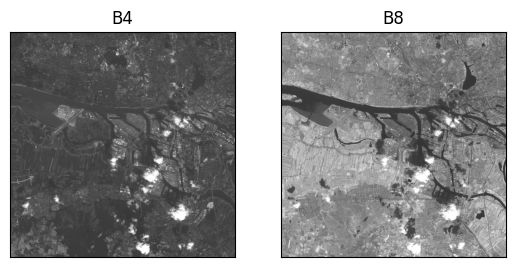

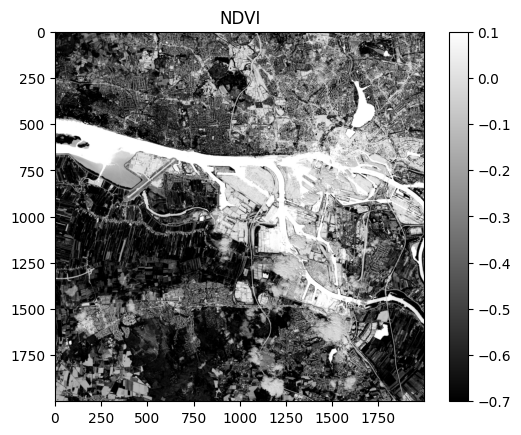

In [126]:
fig, _axs = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=0.5)
axs = _axs.flatten()

axs[0].set_title("B4")
axs[0].tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
axs[0].imshow(b4_data, cmap=mpl.colormaps['gray'], vmin=-0.1, vmax=0.5)

axs[1].set_title("B8")
axs[1].tick_params(axis="both", length=0, labelbottom=False, labelleft=False)
axs[1].imshow(b8_data, cmap=mpl.colormaps['gray'], vmin=-0.1, vmax=0.5)

plt.show(block=True)

fig1, ax1 = plt.subplots()
ax1.set_title("NDVI")
ndvi_image = ax1.imshow(ndvi_data, cmap=mpl.colormaps['gray'], vmin=-0.7, vmax=0.1)
fig1.colorbar(ndvi_image)

##### ***Write NDVI to png file:***

In [127]:
ndvi_image.write_png('ndvi_full.png')

##### ***Dispose the product:***

In [128]:
p.dispose()

---

## **8. Run the workflow using GPF and Snappy**

In this section we basically run the same workflow, but with means of the SNAP GPF framework and the SNAP Python API 'Snappy'.

##### ***Some required imports from esa_snappy:***

In [129]:
from esa_snappy import GPF
from esa_snappy import HashMap
from esa_snappy import Rectangle
from esa_snappy import jpy

##### ***Read L1C product again into SNAP:***

In [130]:
p = ProductIO.readProduct(l1c_product_to_process)

INFO: eu.esa.opt.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32632


##### ***Set up a 'Subset' operator which considers the rectangle defined above:***

In [131]:
subset_op_name = 'Subset'
subset_parameters = HashMap()
subset_parameters.put('sourceBands', 'B4,B8')
subset_rect = Rectangle(xoff,yoff,wsub,hsub)
subset_parameters.put('region', subset_rect)
subset_product = GPF.createProduct(subset_op_name, subset_parameters, p)


100% done.


##### ***Set up a 'BandMaths' operator to compute a simple NDVI. Set up a target band for NDVI result:***

In [132]:
bandmaths_op_name = 'BandMaths'
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
ndvi_band = BandDescriptor()
ndvi_band.name = 'ndvi'
ndvi_band.type = 'float32'
ndvi_band.expression = '(B4 - B8)/(B4 + B8)'
target_bands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 1)
target_bands[0] = ndvi_band
bandmaths_parameters = HashMap()
bandmaths_parameters.put('targetBands', target_bands)
bandmaths_product = GPF.createProduct(bandmaths_op_name, bandmaths_parameters, subset_product)


100% done.


##### ***Additional step: Merge NDVI with bands of subset product :***

In [133]:
merge_op_name = 'BandMerge'
merge_parameters = HashMap()
merge_parameters.put('sourceBands', 'B4,B8,ndvi')
source_products = HashMap()
source_products.put('Subset', subset_product)
source_products.put('BandMaths', bandmaths_product)
merge_product = GPF.createProduct(merge_op_name, merge_parameters, source_products)


100% done.


##### ***Additional step: Write Merge Subset result into a NetCDF file. This file can be downloaded and e.g. opened and visualized in SNAP Desktop:***

In [134]:
ProductIO.writeProduct(merge_product, './ndvi_result_snappy.nc', 'NetCDF4-BEAM')

##### ***Display NDVI result:***

We do a quick (visual) check if we have the same NDVI result as from 'pure Snappy' above. 

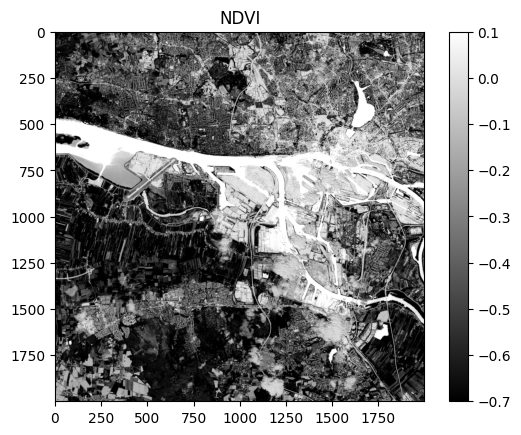

In [135]:
ndvi = merge_product.getBand('ndvi')
w = ndvi.getRasterWidth()
h = ndvi.getRasterHeight()

ndvi_data = np.zeros(w * h, np.float32)
ndvi.readPixels(0, 0, w, h, ndvi_data)
ndvi_data.shape = h, w

fig1, ax1 = plt.subplots()
ax1.set_title("NDVI")
ndvi_image = ax1.imshow(ndvi_data, cmap=mpl.colormaps['gray'], vmin=-0.7, vmax=0.1)
fig1.colorbar(ndvi_image)

ndvi_image.write_png('ndvi.png')

---

## **9. Run the workflow in an XML graph with SNAPISTA**

In this section we run the same workflow once again, but with means of the SNAP Python API 'SNAPISTA' which since SNAP 12 is provided together with Snappy. The section will illustrate the capabilities of SNAPISTA to create, view, run and export SNAP GPT xml graphs in a very simple and user-friendly manner. 

#### **Fill a SNAPISTA graph with nodes:**


##### ***Initialize the graph:***

In [136]:
try:
    g = Graph()
except Exception as ex:
    print("Cannot set up Snapista Graph():", ex)

##### ***Read L1C product again into SNAP:***

With a single line of Python code, a complete node can be created and added to a GPT graph.

In [137]:
g.add_node(operator=Operator("Read", file=l1c_product_to_process), node_id="Read_l1c")

##### ***Set up a 'Subset' operator which considers the rectangle defined above:***

In [138]:
subset_op = Operator('Subset', sourceBands="B4,B8", region='5001, 6001, 2000, 2000')
g.add_node(operator=subset_op, node_id="Subset" ,source='Read_l1c')

##### ***Set up a 'BandMaths' operator to compute a simple NDVI. Set up a target band for NDVI result:***

In [139]:
band_maths_op = Operator('BandMaths')
ndvi = TargetBand(name='ndvi', expression='(B4 - B8)/(B4 + B8)')
band_maths_op.targetBandDescriptors = TargetBandDescriptors([ndvi])
g.add_node(operator=band_maths_op, node_id="BandMaths" ,source='Subset')

targetBandDescriptors <snapista.target_band_descriptors.TargetBandDescriptors object at 0x7f03672a6080>
Instance TargetBandDescriptors: True
Instance Aggregators: False
Instance BinningOutputBands: False
Instance BinningVariables: False
Instance str: False


##### ***Merge NDVI with bands of subset product:***

In [140]:
merge = Operator("BandMerge", sourceBands="B4,B8,ndvi")
g.add_node(operator=merge, node_id="Merge", source=["Subset", "BandMaths"])

##### ***Write Merge Subset result into a file:***

We use NetCDF4-BEAM as output format. Any other format supported by SNAP could be used.

In [141]:
write_ndvi = Operator("Write", file='./ndvi_result_snapista.nc', formatName='NetCDF4-BEAM')
g.add_node(operator=write_ndvi, node_id="WriteNdvi", source='Merge')

##### ***Display the graph:***

In [142]:
g.view()

<graph>
  <version>1.0</version>
  <node id="Read_l1c">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <bandNames/>
      <copyMetadata>true</copyMetadata>
      <file>Sentinel-2/MSI/L1C_N0500/2018/08/03/S2A_MSIL1C_20180803T103021_N0500_R108_T32UNE_20230730T062418.SAFE</file>
      <formatName/>
      <geometryRegion/>
      <maskNames/>
      <pixelRegion/>
      <polygonRegion/>
      <useAdvancedOptions>false</useAdvancedOptions>
      <vectorFile/>
    </parameters>
  </node>
  <node id="Subset">
    <operator>Subset</operator>
    <sources>
      <sourceProduct refid="Read_l1c"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <bandNames/>
      <copyMetadata>false</copyMetadata>
      <fullSwath>false</fullSwath>
      <geoRegion/>
      <polygonRegion/>
      <referenceBand/>
      <region>5001, 6001, 2000, 2000</region>
      <sourceBands>B4,B8</sourceBands>
      <subSampli

##### ***Export the graph:***

The graph can be saved to disk as xml fie. Then, for example, it could be executed with the SNAP 'gpt' command from the command line or in a batch processing chain.

In [143]:
g.save_graph('./lps_workflow_example_graph.xml')

##### ***Run the graph:***

However, we can run the graph here, as SNAPISTA provides a very simple wrapper for the SNAP 'gpt' command to run the graph.

In [144]:
g.run()

Processing the graph, this may take a while. Please wait...
Executing processing graph
..12%...25%..38%..51%..64%..77%..90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
INFO: eu.esa.opt.dataio.s2.ortho.S2OrthoProductReaderPlugIn: Building product reader - EPSG:32632
5723 [main] INFO serverStartup - Nc4Iosp: NetCDF-4 C library loaded (jna_path='/home/jovyan/.snap/auxdata/netcdf_natives/12.0.0/amd64', libname='netcdf').
5727 [main] INFO serverStartup - NetcdfLoader: set log level: old=0 new=0
5727 [main] INFO serverStartup - Nc4Iosp: set log level: old=0 new=0
Processing finished successfully.


0

---

## **10. Compare SNAPISTA NDVI result with the one from Snappy**

Again, we do a quick (visual) check if the SNAPISTA graph process produced the same NDVI result as 'pure Snappy' and 'Snappy with GPF' above. 

##### ***Read SNAPISTA NDVI result NetCDF back into SNAP:***

In [145]:
ndvi_snapista_product = ProductIO.readProduct('./ndvi_result_snapista.nc')

##### ***Display NDVI result:***

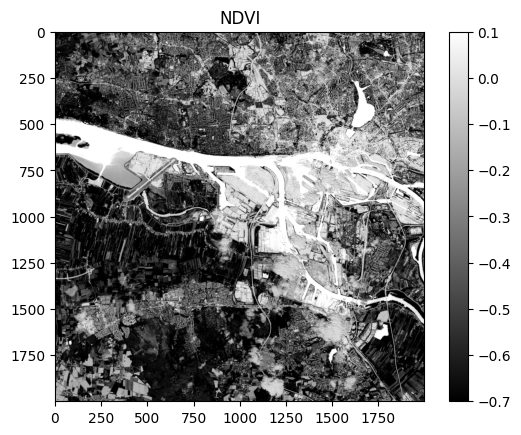

In [146]:
ndvi = ndvi_snapista_product.getBand('ndvi')
w = ndvi.getRasterWidth()
h = ndvi.getRasterHeight()

ndvi_data = np.zeros(w * h, np.float32)
ndvi.readPixels(0, 0, w, h, ndvi_data)
ndvi_data.shape = h, w

fig1, ax1 = plt.subplots()
ax1.set_title("NDVI")
ndvi_image = ax1.imshow(ndvi_data, cmap=mpl.colormaps['gray'], vmin=-0.7, vmax=0.1)
fig1.colorbar(ndvi_image)

---

## **11. Cleanup**
Before ending the notebook, we remove the downloaded source product.

In [147]:
print('Cleanup...')
subprocess.call(["rm", "-Rf", l1c_product_to_process])

print('Notebook finished successfully.')

Cleanup...
Notebook finished successfully.


---

## **12. Summary**

What have we learnt in this notebook?

- How to quickly access satellite imagery using STAC Catalogue API and S3 download.
- How to read a Sentinel-2 L1C product into SNAP
- How to build and run a SNAP gpt graph using SNAP Python API (esa_snappy, Snapista)

---